This notebook allows you to visualize exploration and exploitation statistics for the Exploration in Malmo Continuous Mountain Cart EMC^2 experiment. make sure your data is in the run_saves/ folder.

In [1]:
from __future__ import division
import numpy as np
import os
import pylab
import seaborn
import pickle
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Step 1 load data
data = pickle.load(open("../logs/test_vizu42.pickle","rb"))
bk = pickle.load(open("../logs/test_vizu42_book_keeping.pickle","rb"))
nb_iter = len(data['observations'])

In [3]:
print "{} iterations loaded: {} arm, {} sound".format(nb_iter,
                                                      bk['nb_motor_it'],
                                                      bk['nb_sound_it'])
print bk.keys()
print len(bk['raw_torso_sounds'])
print data.keys()
for k,v in data.items():
    print 'len {}: {}'.format(k,len(v))

16500 iterations loaded: 1578 arm, 14922 sound
['nb_motor_it', 'nb_sound_it', 'raw_torso_sounds', 'nb_culbuto_pronounced', 'nb_culbuto_touched', 'produced_names', 'nb_culbuto_replaced']
14922
['actions', 'sm_data', 'observations', 'chosen_modules', 'goals']
len actions: 16500
len sm_data: 5
len observations: 16500
len chosen_modules: 16500
len goals: 15000


In [4]:
#print bk['nb_culbuto_replaced']
# Define motor and sensory spaces:
s_hand = range(3, 33)
s_culbuto_1 = range(33, 63)
s_self_sound = range(63, 73)
s_caregiver_sound = range(73, 83)

arm_modules = [1,3,6]
diva_modules = [12,14]

# Extract relevant observation sub parts
sub_outcomes = {'hand':{'range': s_hand, 'nb_traj_steps': 10},
                'culbuto':{'range': s_culbuto_1, 'nb_traj_steps': 10},
                'agent_sound':{'range': s_self_sound, 'nb_traj_steps': 5},
                'caregiver_sound':{'range': s_caregiver_sound, 'nb_traj_steps': 5}}
cpt = 0

zero_like = [-0.87179487, -1.     ,     0.73195876, -0.87179487, -1.     ,     0.73195876,
 -0.87179487, -1.     ,     0.73195876, -0.87179487, -1.     ,     0.73195876,
 -0.87179487, -1.     ,     0.73195876, -0.87179487, -1.     ,     0.73195876,
 -0.87179487 ,-1.     ,     0.73195876, -0.87179487, -1.     ,     0.73195876,
 -0.87179487, -1.     ,     0.73195876, -0.87179487,-1.     ,     0.73195876]

culb_replaced = []
zero_like_sum = -11.398361089082734
for n,d in sub_outcomes.items():
    sub_outcomes[n]['traj'] = []
    sub_outcomes[n]['raw'] = []
    for i in range(nb_iter):
        if n == 'culbuto':
            if data['chosen_modules'][i] in diva_modules: # we do not care about objects when vocalizing
                    #print data['chosen_modules'][i]
                    #print sum(data['observations'][i][d['range']])
                    if not sum(data['observations'][i][d['range']]) == zero_like_sum:
                        culb_replaced.append(i)
                        data['observations'][i][d['range']] = zero_like
        sub_outcomes[n]['traj'].append(data['observations'][i][d['range']])
        sub_outcomes[n]['raw'] += np.split(data['observations'][i][d['range']], d['nb_traj_steps'])
    sub_outcomes[n]['raw'] = np.array(sub_outcomes[n]['raw'])
    #print len(sub_outcomes[n]['traj'])
    #print sub_outcomes[n]['raw'].shape
print len(sub_outcomes['hand']['traj'])
print culb_replaced
#print culb_replaced

16500
[9412, 9711, 9903, 9947, 10080, 10539, 11323, 11487, 11850, 11893, 11934, 12617, 12637, 12806, 12841, 13685, 13808, 14376, 15445, 15474, 15564, 15685, 15702, 15769, 15987, 16181]


In [5]:
print sub_outcomes['culbuto']['raw'][0]

[-0.87179487 -1.          0.73195876]


In [6]:
# Compute grid-cell exploration
# Argument:
#   - values: 
print len(np.unique(stats.binned_statistic_dd(sub_outcomes['hand']['raw'],
                                np.arange(len(sub_outcomes['hand']['raw'])),
                                bins = 80,
                                range=[[-1,1],[-1,1],[-1,1]]).binnumber))
print sub_outcomes['culbuto']['raw'].shape

7110
(165000, 3)


In [7]:
nb_runs = 1

# Grid cell exploration curves
metric = ['hand','culbuto','agent_sound']
bins = [80,80,100,100]

nb_metrics = len(metric)
plot_every = 100
plot_steps = np.arange(plot_every,((nb_iter // plot_every)+1)*plot_every,plot_every)
print plot_steps

explo = np.zeros((nb_metrics,nb_runs,len(plot_steps)))
for i, plot_idx in enumerate(plot_steps):
    for m_idx, m in enumerate(metric):
            nb_dims = sub_outcomes[m]['raw'].shape[1]
            samples = sub_outcomes[m]['raw'][:plot_idx,:]
            nb_explored_cells = len(np.unique(stats.binned_statistic_dd(samples,
                                                                        np.arange(len(samples)),
                                                                        bins = bins[m_idx],
                                                                        range=[[-1,1]]*nb_dims).binnumber))
            nb_cells = bins[m_idx]**nb_dims
            explo[m_idx,0,i] = (nb_explored_cells / nb_cells)*100

mean_explo = np.mean(explo,axis=1)
std_explo = np.std(explo,axis=1)
#print mean_explo.shape


[  100   200   300   400   500   600   700   800   900  1000  1100  1200
  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300  2400
  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500  3600
  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700  4800
  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900  6000
  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100  7200
  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300  8400
  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500  9600
  9700  9800  9900 10000 10100 10200 10300 10400 10500 10600 10700 10800
 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000
 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200
 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400
 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600
 15700 15800 15900 16000 16100 16200 16300 16400 16

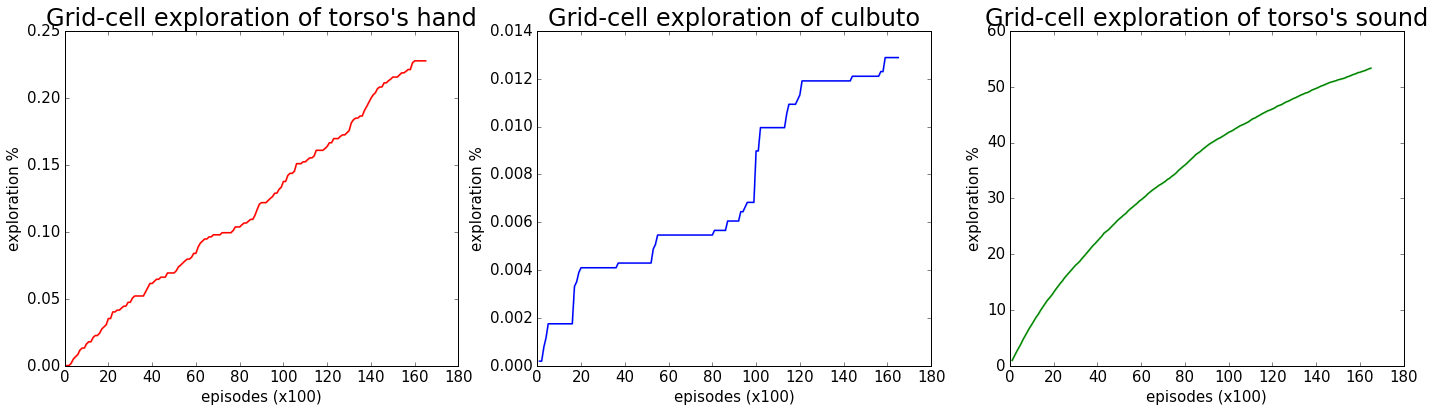

In [8]:
def plot_with_std(ax,x,y,err,color,shade_color,label,y_min=None,y_max=None, legend=False, title=None):
    plt.rcParams.update({'font.size': 15})
    ax.plot(x,y, color=color, label=label,linewidth=1.5)
    ax.fill_between(x,y-err,y+err,color=shade_color,alpha=0.5)
    if legend:
        leg = plt.legend(loc='lower right')
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
    ax.set_xlabel('episodes (x100)')
    ax.set_ylabel('exploration %')
    if y_min is not None:
        ax.ylim(ymin=y_min,ymax=y_max)
    if title:
        ax.set_title(title, fontsize=24)

colors = ['red','blue','green','magenta','black','cyan','orange']
shades_colors = ['lightsalmon','skyblue','lightgreen','violet']
title_info = ["torso's hand", "culbuto", "torso's sound"]
plotpos=[131,132,133]
f, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(24,6))
ax = [ax0, ax1, ax2]
for i,m in enumerate(metric):
    y = mean_explo[i,:]
    err = std_explo[i,:]
    title = 'Grid-cell exploration of '
    plot_with_std(ax[i], plot_steps//100,y,err,colors[i],shades_colors[i],metric[i],
                  title=title+title_info[i])
plt.savefig("grid_cell_exploration.pdf", bbox_inches='tight')
plt.show()


(165000, 3)


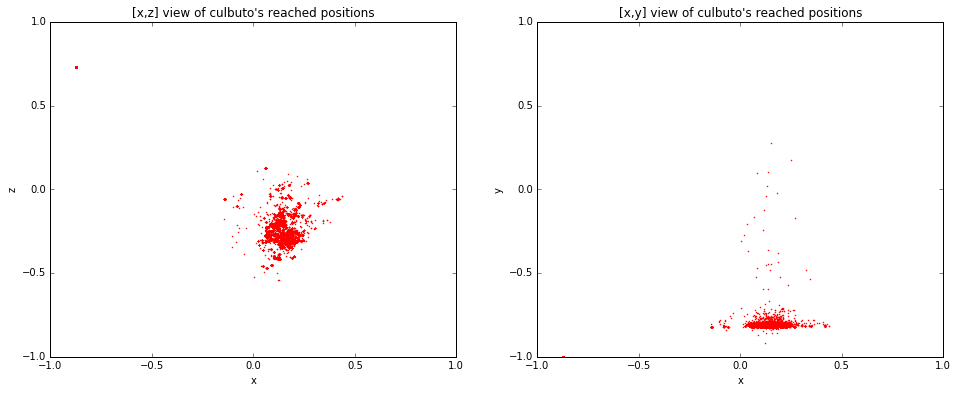

In [15]:
#Quantitative view of culbuto's reached positions
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
a = np.array(sub_outcomes['culbuto']['raw'])
print a.shape
ax1.plot(a[:,0],a[:,2],'r.',markersize=2)
ax1.set_xlim(-1,1)
ax1.set_ylim(-1,1)
ax1.set_xlabel('x')
ax1.set_ylabel('z')
ax1.set_title("[x,z] view of culbuto's reached positions")

ax2.plot(a[:,0],a[:,1],'r.',markersize=2)
ax2.set_xlim(-1,1)
ax2.set_ylim(-1,1)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title("[x,y] view of culbuto's reached positions")

plt.savefig("culbuto_exploration.pdf", bbox_inches='tight')
plt.savefig("culbuto_exploration.png", bbox_inches='tight')
plt.show()


In [10]:
import pickle
from rospkg.rospack import RosPack
import rospy
from os.path import join

# Sound config
def compress_sound_traj(sound):
    assert(len(sound) == 100)
    f1s = sound[:50]
    f3s = sound[50:]
    return np.append(f1s[np.array([0, 12, 24, 37, 49])],f3s[np.array([0, 12, 24, 37, 49])])

v_o = list(np.log2([500, 900]))
v_y = list(np.log2([300, 1700]))
v_u = list(np.log2([300, 800]))
v_e = list(np.log2([400, 2200]))
v_i = list(np.log2([300, 2300]))

# Retrieve caregiver sounds and trajectories from json
rospack = RosPack()
with open(join(rospack.get_path('pobax_playground'), 'config', 'human_sounds.pickle')) as f:
    full_human_motor_traj, full_human_sounds_traj  = pickle.load(f)
human_sounds = full_human_sounds_traj.keys()
rospy.loginfo('Voice node using the word %s for culbuto name' % human_sounds[0])

vowels = dict(o=v_o, y=v_y, u=v_u, e=v_e, i=v_i)

human_sounds = ['eyu', 'oey', 'eou', 'oyi']
print "human sounds", human_sounds

human_sounds_traj = dict()
human_sounds_traj_std = dict()
best_vocal_errors = {}
best_vocal_errors_evolution = []
for hs in human_sounds:
    best_vocal_errors[hs] = 10.
    human_sounds_traj[hs] = compress_sound_traj(full_human_sounds_traj[hs])
    human_sounds_traj_std[hs] = [d - 8.5 for d in human_sounds_traj[hs][:5]] + [d - 10.25 for d in human_sounds_traj[hs][5:]]    
        
sound_tol = 0.4

human sounds ['eyu', 'oey', 'eou', 'oyi']


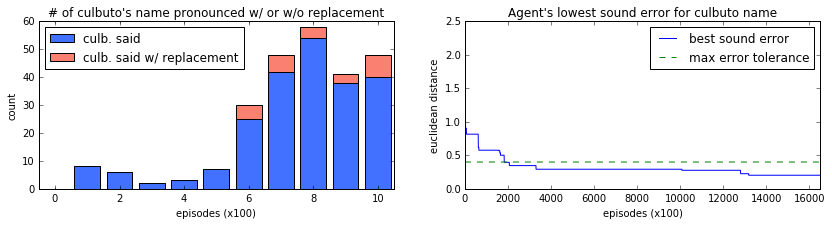

In [11]:
# Plot culbuto name frequency
def analysis_sound(sound, best_vocal_error):
        #return human_sounds[2]
        #print human_sounds_traj
        for hs in human_sounds:
            #sound = np.array([f[0] for f in diva_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in diva_traj[[0, 12, 24, 37, 49]]])
            error = np.linalg.norm(np.array(human_sounds_traj[hs]) - sound)
            if error < best_vocal_error:
                best_vocal_error = error
            if error < sound_tol:
                #print "***********Agent says", hs
                return hs, best_vocal_error
        return None, best_vocal_error

plt.rcParams.update({'font.size': 10})
vocal_errors = []
culb_name_said = []
best_vocal_error = 10.
for i,s in enumerate(sub_outcomes['agent_sound']['traj']):
    #denormalize s
    original_s = [d + 8.5 for d in s[:5]] + [d + 10.25 for d in s[5:]]    
    res, best_vocal_error = analysis_sound(original_s, best_vocal_error)
    vocal_errors.append(best_vocal_error)
    if res == 'eyu':
        culb_name_said.append(i)
        
# Plot sound error evolution
f, (ax2, ax1) = plt.subplots(1,2,figsize=(14,3))
ax1.plot(vocal_errors,color='blue',label='best sound error')
ax1.plot([sound_tol]*len(vocal_errors),ls='--',
         color='green', 
         label='max error tolerance')
ax1.set_title("Agent's lowest sound error for culbuto name")
ax1.set_ylabel('euclidean distance')
ax1.set_xlabel('episodes (x100)')
ax1.set_xlim(0,len(vocal_errors))
ax1.legend()

# Barplot plot
culb_said_not_replaced = []
culb_said_replaced = []
for episode in culb_name_said:
    if episode in culb_replaced:
        culb_said_replaced.append(episode)
    else:
        culb_said_not_replaced.append(episode)
barplot_step = 1500
barplot_steps = np.arange(0,((nb_iter // barplot_step)+1)*barplot_step,barplot_step)
count_culb_not_replaced = stats.binned_statistic(culb_said_not_replaced,
                             np.arange(len(culb_said_not_replaced)),
                             statistic='count',
                             bins=barplot_steps).statistic

count_culb_replaced = stats.binned_statistic(culb_said_replaced,
                             np.arange(len(culb_said_replaced)),
                             statistic='count',
                             bins=barplot_steps).statistic

width = 0.8      # the width of the bars: can also be len(x) sequence
ind = np.arange(len(count_culb_replaced))    # the x locations for the groups
p1 = ax2.bar(ind, count_culb_not_replaced, color=(0.2588,0.4433,1.0),align='center', width=width)
p2 = ax2.bar(ind, count_culb_replaced, color='salmon', bottom=count_culb_not_replaced,align='center', width=width)

ax2.set_ylabel('count')
ax2.set_xlabel('episodes (x100)')
ax2.set_title("# of culbuto's name pronounced w/ or w/o replacement")

#plt.xticks()
#ax.set_yticks(np.arange(0, 81, 10))
x_labels= []
for i,val in enumerate(barplot_steps):
    if i < len(barplot_steps)-1:
        x_labels.append(str(val//100)+'-'+str(barplot_steps[i+1]//100))

ax2.set_xticks(ind[0::2],x_labels[0::2])
ax2.set_xlim(min(ind)-0.5,max(ind)+0.5)
ax2.legend((p1[0],p2[0]),('culb. said','culb. said w/ replacement'), loc=2)

plt.savefig("culbuto_name_pronounced.pdf", bbox_inches='tight')
plt.show()
        

In [12]:
np.arange(0,16500,2500)

array([    0,  2500,  5000,  7500, 10000, 12500, 15000])

In [13]:
a = [1,2,3,4]
print a[0::2]

[1, 3]


In [14]:
plot_steps//100

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165])